In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import seaborn as sns

# Proecessing and Modeling Rossmann Sales Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

Id - an Id that represents a (Store, Date) duple within the test set \
Store - a unique Id for each store\
Sales - the turnover for any given day (this is what you are predicting)\
Customers - the number of customers on a given day\
Open - an indicator for whether the store was open: 0 = closed, 1 = open\
StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None\
SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools\
StoreType - differentiates between 4 different store models: a, b, c, d\
Assortment - describes an assortment level: a = basic, b = extra, c = extended\
CompetitionDistance - distance in meters to the nearest competitor store\
CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened\
Promo - indicates whether a store is running a promo on that day\
Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating\
Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2\
PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store \

Read Files

In [4]:
train = pd.read_csv('../data/train_store_combined.csv')
test = pd.read_csv('../data/test_store_combined.csv')

## Feature Engineering

Create a is weekend feature. This also covers the is weekday since they have a perfectly negative correlations

In [5]:
def isWeekend(x):
    if x<6:
        return 0
    else: 
        return 1
train["weekend"]= train["DayOfWeek"].apply(isWeekend )

This creates the feature if the day is at the start mid or end of the month

In [6]:
def startMidEndMonth(x):
    if x<10:
        return 0
    elif x<20:
        return 1
    else:
        return 2

In [7]:
train["MonthState"]=train["Day"].apply(startMidEndMonth)

In [91]:
import bisect
train["Date"]=pd.to_datetime(train["Date"])
dates=np.array(train[train["StateHoliday"]!="0"]["Date"].unique())
dates=np.sort(dates)
a=train["Date"].iloc[119]

index = bisect.bisect(dates, a)
print(index,dates[index-1],dates[index])

32 2015-04-03T00:00:00.000000000 2015-04-06T00:00:00.000000000


This is to create a days to and after a holiday with a list of holidays

In [9]:
def datToAndAfterHoliday(df,Column,holidays):
    to=[]
    after=[]
    for a in df[Column]:
        index=bisect.bisect(holidays,a)
        if len(holidays)==index:
            to.append(pd.Timedelta(0, unit='d') )
            after.append(a - holidays[index-1])
        else:
            after.append(holidays[index] - a)
            to.append(a -holidays[index-1])
    return to,after

In [10]:
train["To"],train["After"]=datToAndAfterHoliday(train,"Date",dates)

Fill the null values

In [11]:
train['Promo2SinceWeek'] = train['Promo2SinceWeek'].fillna(train['Promo2SinceWeek'].max())
train['Promo2SinceYear'] = train['Promo2SinceYear'].fillna(train['Promo2SinceYear'].max())
train['PromoInterval'] = train['PromoInterval'].fillna(train['PromoInterval'].mode().iloc[0])

train['CompetitionDistance'] = train['CompetitionDistance'].fillna(train['CompetitionDistance'].max())
train['CompetitionOpenSinceMonth'] = train['CompetitionOpenSinceMonth'].fillna(train['CompetitionOpenSinceMonth'].mode().iloc[0])
train['CompetitionOpenSinceYear'] = train['CompetitionOpenSinceYear'].fillna(train['CompetitionOpenSinceYear'].mode().iloc[0])

In [12]:
# train.to_csv("../data/test_store_combined.csv",index=False)

The final form of our data

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype          
---  ------                     --------------    -----          
 0   Store                      1017209 non-null  int64          
 1   DayOfWeek                  1017209 non-null  int64          
 2   Date                       1017209 non-null  datetime64[ns] 
 3   Sales                      1017209 non-null  int64          
 4   Customers                  1017209 non-null  int64          
 5   Open                       1017209 non-null  int64          
 6   Promo                      1017209 non-null  int64          
 7   StateHoliday               1017209 non-null  object         
 8   SchoolHoliday              1017209 non-null  int64          
 9   Year                       1017209 non-null  int64          
 10  Month                      1017209 non-null  int64          
 11  Day                     

In [14]:
# train_cleaned_ready=train.copy()

Manually fixing/modifying the data

In [15]:
# train_cleaned_ready["To"]=pd.to_numeric(train_cleaned_ready['To'].dt.days, downcast='integer')

In [16]:
train["To"]=pd.to_numeric(train['To'].dt.days, downcast='integer')

In [17]:
train["After"]=pd.to_numeric(train['After'].dt.days, downcast='integer')

In [18]:
# train_cleaned_ready["After"]=pd.to_numeric(train_cleaned_ready['After'].dt.days, downcast='integer')

In [19]:
# train_cleaned_ready.drop(["Store","Date","Customers"],axis=1,inplace=True)

Function to encode and scale our data

In [20]:
def encode_scale_features(df,columns):
    lb=LabelEncoder()
    norm = StandardScaler()
    for i in columns:
        df[i]=lb.fit_transform(df[i])   
    norm_fit = norm.fit_transform(df)
    out=pd.DataFrame(norm_fit,columns=df.columns)
    return out

In [21]:
# features=encode_scale_features(train_cleaned_ready,["StoreType","StateHoliday","Assortment","PromoInterval"])

Select our target

In [22]:
# y=features["Sales"]

Drop our target

In [23]:
# features=features.drop("Sales",axis=1,inplace=False)

## Modeling without pipeline

Import our Model Class from previous project

In [2]:


import sys, os

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from Create_modelss_modified import CreateModel



In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [26]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error

Split our data into a train and test set

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(
#    features, y, test_size=0.4, random_state=1)

Create our object

In [29]:
# linearmodel=CreateModel(X_train=X_train,X_test=X_test, y_train=y_train,y_test=y_test,data_version="v1",name="LinearRegressionModel",model=LinearRegression)

Train our baseline model

In [30]:
# linearmodel.train()


Create a hyper parameter tuned version of our model

In [31]:
# params = {'fit_intercept': [True,False],'normalize':[True,False]}

# linearmodel.hyperParameterTune(5,search_space=params)

Create a random forest regressor model

In [32]:
# from sklearn.ensemble import RandomForestRegressor

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# regressionModel=CreateModel(X_train=X_train,X_test=X_test, y_train=y_train,y_test=y_test,data_version="v1",name="RandomForestRegressorModel",model=RandomForestRegressor)  




Train our baseline model

In [33]:
# regressionModel.train()

## Pipeline Processing

Create a custom imputer to handle null values with max. We want to fill values competition distance, promo2year and promo2months with the maximum because they need to be the farthest and the most recent they can be

In [34]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer


In [3]:
from CustomMaxImputer import CustomMaxImputer

In [35]:
# train_cleaned_ready.columns

Extract the target and train featuers

In [36]:
# train = pd.read_csv('../data/train_store_combined.csv')


y = train[['Sales']]
X = train.drop(['Sales',"Customers","Store","Date"], axis=1)

Import pipeline and imputer classes

In [37]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

Dense transformer for use in creating dense versions of frames for parts that take only dense data

In [38]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [39]:
def optimize_df(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
       A simple function which optimizes the data types of the dataframe and returns it
        Parameters
        ----------
        dataframe:
            Type: pd.DataFrame

        Returns
        -------
        pd.DataFrame
    """
    data_types = dataframe.dtypes
    optimizable = ['float64', 'int64']
    for col in data_types.index:
        if(data_types[col] in optimizable):
            if(data_types[col] == 'float64'):
                # downcasting a float column
                dataframe[col] = pd.to_numeric(
                    dataframe[col], downcast='float')
            elif(data_types[col] == 'int64'):
                # downcasting an integer column
                dataframe[col] = pd.to_numeric(
                    dataframe[col], downcast='unsigned')

    return dataframe

In [40]:
# X=optimize_df(X)

Creating our pipeline and spliting the data into train and test sets. We create three input pipelines for numeric and scaled which are imputed with most frequent, max which are imputed with max  and scaled and categorical values which are imputed with most frequent and encoded. 

In [48]:
numeric_features = ['DayOfWeek', 'Open',"Promo","SchoolHoliday","Year","CompetitionOpenSinceMonth","CompetitionOpenSinceYear","weekend","MonthState","To","After","Month","Day","Promo2"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())])

max_features=["Promo2SinceWeek","CompetitionDistance","Promo2SinceYear"]
max_transformenr=Pipeline(steps=[
    ('imputer', CustomMaxImputer()),
    ('scaler', StandardScaler())]
)

categorical_features = ['StateHoliday', 'PromoInterval', 'Assortment','StoreType']

categorical_transformer =Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder',OrdinalEncoder())
    ]) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('max', max_transformenr, max_features),
        ('cat', categorical_transformer, categorical_features)
        ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


Build a baseline linear regression model with our pipeline. The code for processing and modeling is a lot cleaner than the manual versin

In [84]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="Baseline_LinearRegression"):
        
    linearPipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LinearRegression())])
    mod=linearPipeline.fit(X_train, y_train)

    linearPrediction = linearPipeline.predict(X_test)
    linearError=mean_squared_error(y_test,linearPrediction)

print("mean_squared_error of model is ",linearError)


mlflow.end_run()


2021/07/31 18:30:09 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                    ...`
2021/07/31 18:30:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('sca...`
2021/07/31 18:30:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())]), ['DayOfWeek', 'Open', 'Promo', 'SchoolHol

mean_squared_error of model is  6500671.41290929


In [49]:
# import math
# math.sqrt(error)

In [50]:
# clf.score(X_test,y_test)

In [51]:
# result_df = X_test.copy()
# result_df["Prediction Sales"] = pred
# result_df["Actual Sales"] = y_test
# result_df["Store"]=test["Store"]
# result_agg = result_df.groupby("Store").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})
        
    
def pred_graph(res_dataframe):
    
    fig = plt.figure(figsize=(18, 5))
    sns.lineplot(x = res_dataframe.index, y = res_dataframe["Actual Sales"], label='Actual')
    sns.lineplot(x = res_dataframe.index, y = res_dataframe["Prediction Sales"], label='Prediction')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel="Day", fontsize=16)
    plt.ylabel(ylabel="Sales", fontsize=16)
    plt.show()

In [52]:
# pred_graph(result_agg)

In [53]:
from sklearn.ensemble import RandomForestRegressor

Creating a baseline random forest model 

In [54]:


mlflow.sklearn.autolog()

with mlflow.start_run(run_name="Baseline_RandomForest"):
        
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestRegressor(n_estimators=15))])
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    error=mean_squared_error(y_test,pred)
    
    mlflow.log_metric("mean_squared_error", error)

print("mean_squared_error of model is ",error)


In [55]:
# result_df = X_test.copy()
# result_df["Prediction Sales"] = pred
# result_df["Actual Sales"] = y_test
# result_df["Store"]=test["Store"]
# result_agg = result_df.groupby("Day").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})

# pred_graph(result_agg)

In [56]:

# result_month_agg = result_df.groupby("Month").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})

# pred_graph(result_month_agg)

In [57]:

# from sklearn.metrics import mean_absolute_error


# mean_absolute_error(y_test,pred)

In [58]:
import pickle

Creating a hyper parameter tuned randomforest regressor with our pipeline 

In [60]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
mlflow.sklearn.autolog()
param_grid = {
    'classifier__bootstrap': [True],
    'classifier__max_depth': [5, 6, 7, 15],
    'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
    'classifier__min_samples_split': [4, 5, 6],
    'classifier__n_estimators': [5,10,15,20]
}
with mlflow.start_run(run_name="Hyperparameter_RandomForest"):
        
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestRegressor())])

    grid=GridSearchCV(clf,
                    param_grid=param_grid,
                    cv=2,
                    refit=True)

    grid.fit(X_train, y_train)

    pred = grid.predict(X_test)
    error=mean_squared_error(y_test,pred)
    
    mlflow.log_metric("mean_squared_error", error)

print("mean_squared_error of model is ",error)
mlflow.end_run()




2021/07/31 16:11:44 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpute...`
2021/07/31 16:27:25 INFO mlflow.sklearn.utils: Logging the 5 best runs, 67 runs will be omitted.
2021/07/31 16:27:25 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                    ...`
2021/07/31 16:27:25 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=

mean_squared_error of model is  3839651.623869199


In [ ]:
# grid.named_steps['preprocessor'].get_feature_names()

pickling our models

In [61]:

pickle.dump(grid.best_estimator_, open("../models/model.pkl", 'wb'))

In [92]:

pickle.dump(grid.best_estimator_, open("../models/model2.pkl", 'wb'),protocol=4)

Feature importances of our features

In [66]:



feature_importances = pd.DataFrame((grid.best_estimator_.named_steps['classifier'].feature_importances_).transpose() , index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

feature_importances

,importance
DayOfWeek,0.179223
Open,0.290633
Promo,0.123837
StateHoliday,0.001823
SchoolHoliday,0.004544
Year,0.019832
Month,0.018754
Day,0.115542
StoreType,0.002943
Assortment,0.019053


Visualization of the importances

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

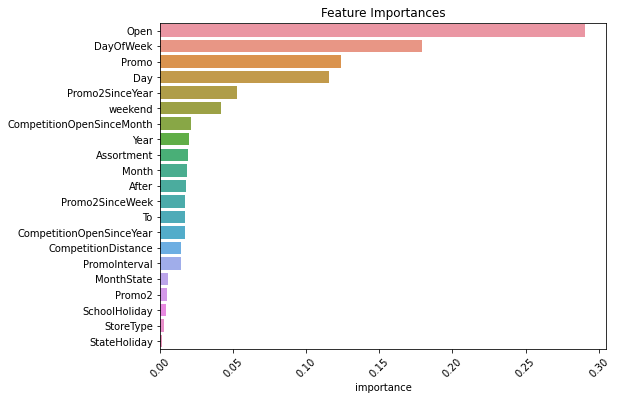

In [89]:
plt.figure(figsize = (8,6))
feature_importances.sort_values('importance', ascending = False, inplace= True)
sns.barplot(y = feature_importances.index, x = feature_importances.importance)
plt.title('Feature Importances')
plt.xticks(rotation = 45)

Load model from mlflow of a previous run with one hot encoded categorical featuers

In [90]:

logged_model = 'runs:/147aa687a9354f3fb5ed2fa715ec1639/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(logged_model)

# Predict on a Pandas DataFrame.
loadedPrediction=loaded_model.predict(X_test)

error=mean_squared_error(y_test,loadedPrediction)


print("mean_squared_error of model is ",error)

mean_squared_error of model is  705529.630655003


We can see the effect that various categorical values have on our model

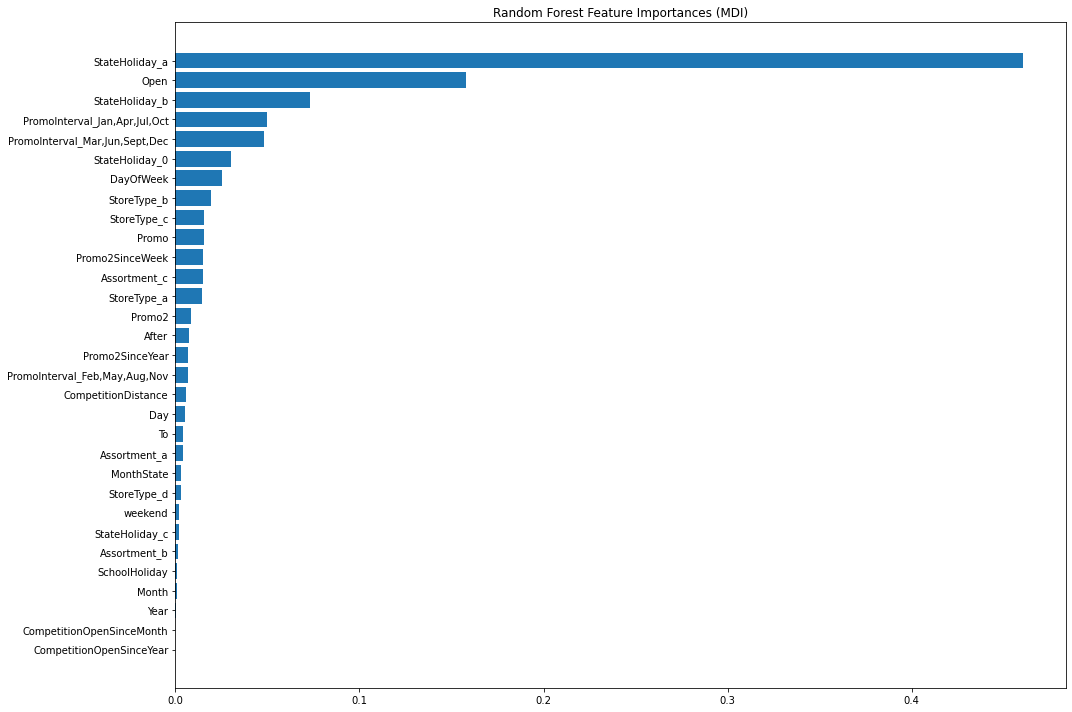

In [ ]:
ohe = (loaded_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'])
feature_names = ohe.get_feature_names(input_features=categorical_features)
feature_names = np.r_[feature_names, numeric_features]
feature_names = np.r_[feature_names, max_features]

tree_feature_importances = (
    loaded_model.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [ ]:
logged_model = 'runs:/b6234db1853e4988b0437abb054dfc8b/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(logged_model)



feature_importances = pd.DataFrame((loaded_model.feature_importances_).transpose() , index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)